In [7]:
# [Cell] 라이브러리 & 데이터 로드
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

# 데이터 로드 (사용자 경로 그대로)
train_df = pd.read_csv("../../../../data/processed/train.csv")
test_df  = pd.read_csv("../../../../data/processed/test.csv")

TARGET = "Revenue"

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(int)

X_test  = test_df.drop(columns=[TARGET])
y_test  = test_df[TARGET].astype(int)

# 컬럼 타입 자동 분리
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("num_cols:", len(num_cols), "cat_cols:", len(cat_cols))
print("Positive rate(train):", float(y_train.mean()))


Train: (9864, 18) Test: (2466, 18)
num_cols: 15 cat_cols: 3
Positive rate(train): 0.15470397404703973


In [3]:
# [Cell] 공통 함수들

def make_preprocessor(scale_numeric: bool):
    """
    - cat: (impute most_frequent) + OHE(ignore unknown)
    - num: (impute median) + (optional) StandardScaler
    """
    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_steps.append(("scaler", StandardScaler()))

    numeric_tf = Pipeline(steps=num_steps)

    categorical_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, num_cols),
            ("cat", categorical_tf, cat_cols),
        ],
        remainder="drop"
    )
    return preprocessor


def get_feature_names(preprocessor: ColumnTransformer):
    """OHE 이후 전체 feature name 뽑기(Feature importance/coef 시각화용)."""
    # numeric
    num_names = list(num_cols)

    # categorical (OHE)
    if len(cat_cols) > 0:
        ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
        cat_names = list(ohe.get_feature_names_out(cat_cols))
    else:
        cat_names = []

    return np.array(num_names + cat_names, dtype=object)


def evaluate_binary(model, X_te, y_te):
    y_pred = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        y_proba = None

    out = {
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_te, y_proba) if y_proba is not None else np.nan
    }
    return out, y_pred, y_proba


def plot_cm(y_true, y_pred, title):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, values_format="d", cmap="Blues")
    plt.title(title)
    plt.grid(False)
    plt.show()


def plot_roc(model, X_te, y_te, title):
    if hasattr(model, "predict_proba"):
        RocCurveDisplay.from_estimator(model, X_te, y_te)
        plt.title(title)
        plt.grid(True, alpha=0.2)
        plt.show()
    else:
        print("ROC curve skipped: predict_proba 없음")


def plot_top_importance(names, values, title, topk=20):
    idx = np.argsort(values)[::-1][:topk]
    plt.figure(figsize=(8, max(4, topk * 0.25)))
    plt.barh(np.array(names)[idx][::-1], np.array(values)[idx][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [4]:
# [Cell] (공통) 결과 저장용
results = {}
fitted_models = {}


[LogReg] {'accuracy': 0.8519870235198702, 'precision': 0.515370705244123, 'recall': 0.7460732984293194, 'f1': 0.6096256684491979, 'roc_auc': 0.8958582468269839}


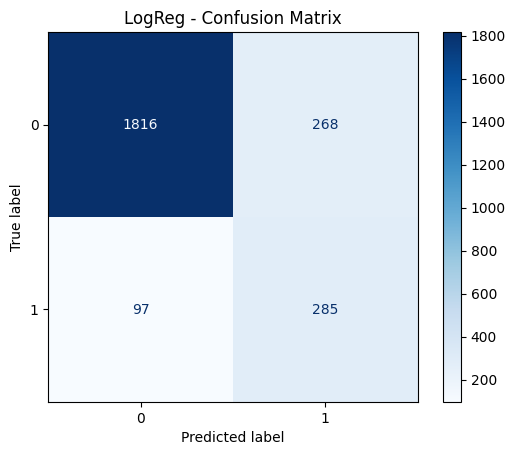

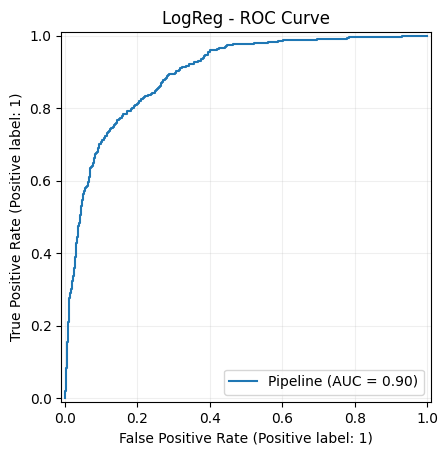

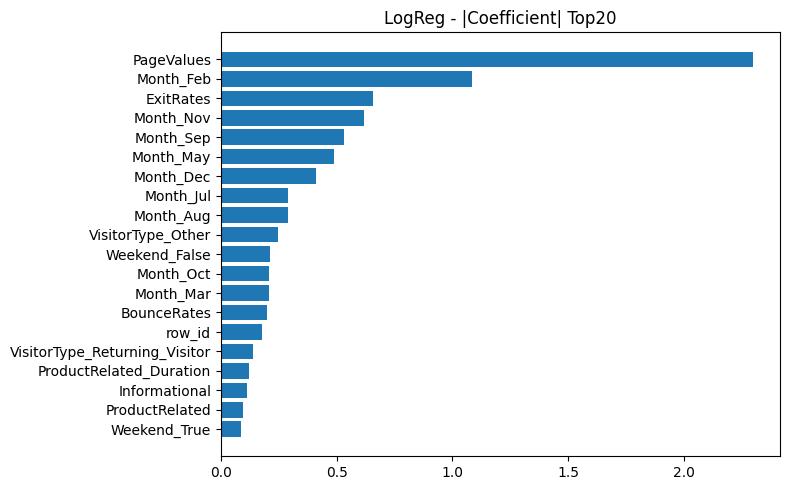

NameError: name 'classification_report' is not defined

In [6]:
# [Cell] 1) Logistic Regression (학습 + 평가 + 시각화)

from sklearn.linear_model import LogisticRegression

preprocessor = make_preprocessor(scale_numeric=True)

clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=None,
    random_state=42
)

pipe_lr = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", clf)
])

pipe_lr.fit(X_train, y_train)

metrics, y_pred, y_proba = evaluate_binary(pipe_lr, X_test, y_test)
results["LogReg"] = metrics
fitted_models["LogReg"] = pipe_lr

print("[LogReg]", metrics)

plot_cm(y_test, y_pred, "LogReg - Confusion Matrix")
plot_roc(pipe_lr, X_test, y_test, "LogReg - ROC Curve")

# Coef(절대값 큰 순) 시각화
feat_names = get_feature_names(pipe_lr.named_steps["prep"])
coef = pipe_lr.named_steps["model"].coef_.ravel()
plot_top_importance(feat_names, np.abs(coef), "LogReg - |Coefficient| Top20", topk=20)
print(classification_report(clf))